In [1]:
using Sundials
using Arrhenius
using ForwardDiff
using LinearAlgebra
using DiffEqSensitivity
using DifferentialEquations

using Random
using ProgressBars
using DelimitedFiles
using Plots, Colors, Printf, Profile

using Flux
using Flux.Optimise: update!
using Flux.Losses: mae, mse

## Load data

In [2]:
# Load cantera data for comparision
cantera_data = readdlm("cantera/data_T_BFG.txt");
ct_t = cantera_data[:, 1];
ct_T = cantera_data[:, 2];
ct_Y = cantera_data[:, 3:end];
ct_u = hcat(ct_Y, ct_T)';

# create Arrhenius.jl Solution object
gas = CreateSolution("./cantera/CH4_Kazakov_without_NOx.yaml");
ns = gas.n_species;
P = one_atm;
Y0 = ct_Y[1, :];
T0 = ct_T[1];
u0 = vcat(Y0, T0);

In [3]:
# Set inlet conditions
Xin_fuels = [
    Dict("H2"=>0.025, "CO"=>0.225, "CH4"=>0.00, "N2"=>0.75),  # BFG
    Dict("H2"=> 0.50, "CO"=> 0.09, "CH4"=>0.30, "N2"=>0.11), # COG_1
    # Dict("H2"=> 0.60, "CO"=> 0.09, "CH4"=>0.25, "N2"=>0.06), # COG_2
];
phi = 1;

Yin_arr = []
for Xf in Xin_fuels
    XO2 = Xf["H2"]*0.5 + Xf["CO"]*0.5 + Xf["CH4"]*2;
    Xin = zeros(ns);
    for (s, v) in Xf
        Xin[species_index(gas, s)] = v * phi;
    end
    Xin[species_index(gas, "O2")] = XO2;
    Xin[species_index(gas, "N2")] += XO2*3.76;
    Xin = Xin ./ sum(Xin);
    Yin = X2Y(gas, Xin, dot(Xin, gas.MW))
    push!(Yin_arr, deepcopy(Yin))
end

#u0 = vcat(Yin_arr[1], T0);

In [352]:
solver = TRBDF2();
reltol = 1e-9
abstol = 1e-12
sensealg = ForwardDiffSensitivity()

datasize = 50;
tsteps = range(0, 5, length=datasize);
tspan = [0.0, tsteps[end]*1.001];

In [353]:
# BCs
Tin = 300;
Ta = 873;
Q = 1000;
tres0 = 1.0;

# fuel switch
function cf_switch_rate(t; tbegin=0.3, tend=0.7)
    if t < tbegin
        Cr = 0;
    elseif t < tend
        Cr = (t - tbegin) / (tend - tbegin);
    else
        Cr = 1;
    end
    Fr = 1
    return  vcat(Cr, Fr);
end

# fuel and flow fluctuatation  amplitude, frequency, phase offset
function cf_fluctuate_rate(t; CRa = 0.03, CF = 0.05, Cp=pi*0.5,
                              FRa = 0.10, FF = 1.00, Fp=pi*0)
    #rng = MersenneTwister(floor(Int64, t*1e10));
    Cr = CRa * sin((t+Cp)*2*pi*CF) / 2 # + rand(rng) * CRa * 0.1;
    Fr = FRa * sin((t+Fp)*2*pi*FF) / 2 # + rand(rng) * FRa * 0.1;
    return vcat((1 + Cr), (1 + Fr));
end

# fuel and flow fluctuatation        frequency, phase offset
function cf_fluctuate(t; CRa = 0.03, CF = 0.05, Cp=pi*0.5,
                         FRa = 0.10, FF = 1.00, Fp=pi*0 )
    Cr = CRa * sin((t+Cp)*2*pi*CF) / 2;
    Fr = FRa * sin((t+Fp)*2*pi*FF) / 2;
    Yin = Yin_arr[1] .* (1 + Cr);
    tres = tres0 * (1 + Fr);
    return vcat(Yin, tres);
end

cf_fluctuate (generic function with 1 method)

In [354]:
CF = 0.2; # fuel flunctuate frequency
FF = 1;   # flow flunctuate frequency

In [355]:
# If we have multiple Neural Network, we can concat them
@inbounds function dudt!(du, u, p, t)
    cf_rate = cf_fluctuate_rate(t; CF = CF, FF = FF)
    Yin = Yin_arr[1] .* cf_rate[1] .+ Yin_arr[2] .* (1-cf_rate[1]);
    tres = tres0 * cf_rate[2];

    T = u[end]
    Y = @view(u[1:ns])
    mean_MW = 1.0 / dot(Y, 1 ./ gas.MW)
    ρ_mass = P / R / T * mean_MW
    X = Y2X(gas, Y, mean_MW)
    C = Y2C(gas, Y, ρ_mass)
    cp_mole, cp_mass = get_cp(gas, T, X, mean_MW)
    h_mole = get_H(gas, T, Y, X)
    S0 = get_S(gas, T, P, X)
    wdot = wdot_func(gas.reaction, T, C, S0, h_mole)
    Ydot = @. wdot / ρ_mass * gas.MW + (Yin - Y) / tres
    Tdot =
        -dot(h_mole, wdot) / ρ_mass / cp_mass +
        (Tin - T) / tres +
        Q * (Ta - T) / ρ_mass / cp_mass
    du .= vcat(Ydot, Tdot)
end
prob = ODEProblem(dudt!, u0, tspan);

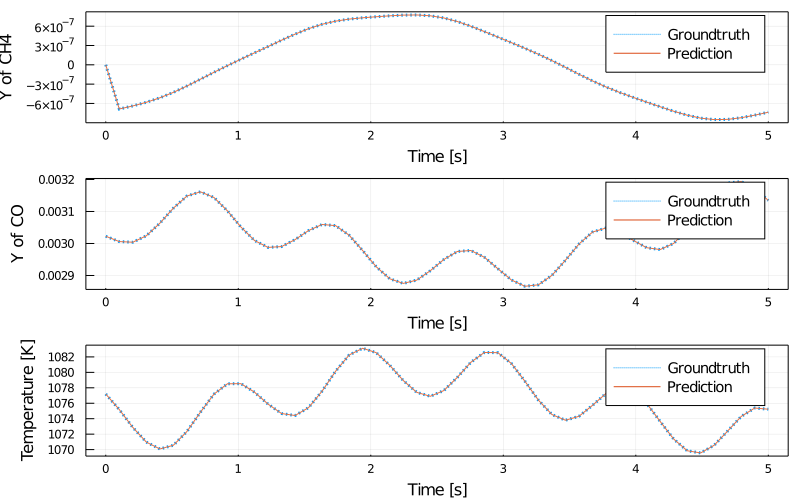

In [356]:
sol = solve(prob, solver, reltol=reltol, abstol=abstol, saveat=tsteps);
y_true = Array(sol);

valid(tsteps, y_true, y_true)
#nn_inlet((tsteps./tscale)')

In [591]:
tscale = tsteps[end] / (2*pi) / 5;

# combined network for c and f
nn_inlet = Chain(x->x, Dense(1, 5, sin), Dense(5, 2, exp));
p_rand, re = Flux.destructure(nn_inlet);

# # seperated network for c and f
# nn_c = Chain(x->x, Dense(1, 5, sin), Dense(5, 1, exp));
# nn_f = Chain(x->x, Dense(1, 5, sin), Dense(5, 1, exp));
# nn_inlet = Chain(x -> cat(nn_c(x), nn_f(x), dims=1))
# pc, rec = Flux.destructure(nn_c);
# pf, ref = Flux.destructure(nn_f);
# p_rand = vcat(pc, pf)
# function re(p)
#     l = length(p)>>1;
#     pc = p[1:l];
#     pf = p[l+1:end];
#     nn_inlet = Chain(x -> cat(rec(pc)(x), ref(pf)(x), dims=1));
#     return nn_inlet;
# end

# totally random start
p_init = deepcopy(p_rand./10)
p_pred = deepcopy(p_init);
p_true = deepcopy(p_rand);

data = hcat([cf_fluctuate_rate(t; CF = CF, FF = FF) for t in tsteps]...)

loss(p) = mse(re(p)((tsteps./tscale)'), data)

loss (generic function with 2 methods)

In [592]:
opt = ADAMW(0.02);
n_epoch = 5000;

for epoch in 1:n_epoch
    global p_true
    grad = ForwardDiff.gradient(x->loss(x), p_true)
    update!(opt, p_true, grad)
end

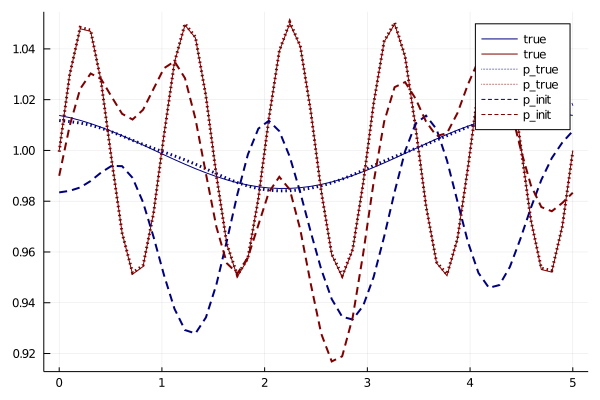

In [596]:
# similar start
rng = MersenneTwister(0x7777777);
#p_init = exp.(0.5*(2*rand(rng, length(p_true)).-1)) .* p_true;
p_init = (0.05*(2*rand(rng, length(p_true)).-1)) .+ p_true;
p_pred = deepcopy(p_init);

plot(palette=palette(:jet, 2))
plot!(tsteps, data', line=(1,:solid), label="true")
plot!(tsteps, re(p_true)((tsteps./tscale)')', line=(3,:dot), label="p_true")
plot!(tsteps, re(p_init)((tsteps./tscale)')', line=(2,:dash), label="p_init")

In [597]:
@inbounds function nndudt!(du, u, p, t)
    global rep;
    cf_rate = rep([t]./tscale);
    Yin = Yin_arr[1] .* cf_rate[1] .+ Yin_arr[2] .* (1-cf_rate[1]);
    tres = tres0 * cf_rate[2];;
    
    T = u[end]
    Y = @view(u[1:ns])
    mean_MW = 1.0 / dot(Y, 1 ./ gas.MW)
    ρ_mass = P / R / T * mean_MW
    X = Y2X(gas, Y, mean_MW)
    C = Y2C(gas, Y, ρ_mass)
    cp_mole, cp_mass = get_cp(gas, T, X, mean_MW)
    h_mole = get_H(gas, T, Y, X)
    S0 = get_S(gas, T, P, X)
    wdot = wdot_func(gas.reaction, T, C, S0, h_mole)
    Ydot = @. wdot / ρ_mass * gas.MW + (Yin - Y) / tres
    Tdot =
        -dot(h_mole, wdot) / ρ_mass / cp_mass +
        (Tin - T) / tres +
        Q * (Ta - T) / ρ_mass / cp_mass
    du .= vcat(Ydot, Tdot)
end
probnn = ODEProblem(nndudt!, u0, tspan, p_init);

# rep = re(p_true);
# y_true = solve(probnn, p=p_true, solver, saveat=tsteps,
#         reltol=reltol, abstol=abstol, sensealg=sensealg);

rep = re(p_init);
y_init = solve(probnn, p=p_init, solver, saveat=tsteps,
        reltol=reltol, abstol=abstol, sensealg=sensealg);

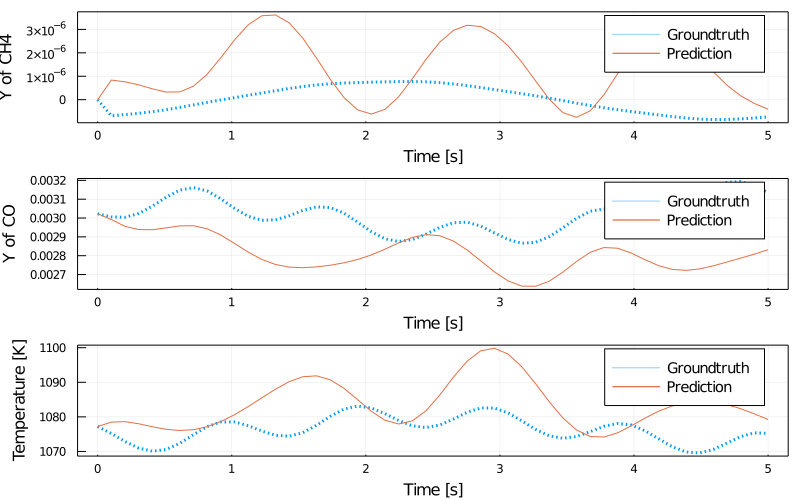

In [598]:
fs = 10;

function valid(t, y_true, y_pred)
    IJulia.clear_output(true)
    
    h1 = plot(legend=true, legendfontsize=fs)#, foreground_color_legend=nothing)
    plot!(t, y_true[species_index(gas, "CH4"),:], line=(3,:dot), label="Groundtruth")
    plot!(t, y_pred[species_index(gas, "CH4"),:], line=(1,:solid), label="Prediction")
    ylabel!(h1, "Y of CH4")
    xlabel!(h1, "Time [s]")

    h2 = plot(legend=true, legendfontsize=fs)#, foreground_color_legend=nothing)
    plot!(t, y_true[species_index(gas, "CO"),:], line=(3,:dot), label="Groundtruth")
    plot!(t, y_pred[species_index(gas, "CO"),:], line=(1,:solid), label="Prediction")
    ylabel!(h2, "Y of CO")
    xlabel!(h2, "Time [s]")
    
    h3 = plot(legend=true, legendfontsize=fs)#, foreground_color_legend=nothing)
    plot!(t, y_true[end,:], line=(3,:dot), label="Groundtruth")
    plot!(t, y_pred[end,:], line=(1,:solid), label="Prediction")
    ylabel!(h3, "Temperature [K]")
    xlabel!(h3, "Time [s]")
    
    h = plot(h1, h2, h3,
        layout=(3,1), size=(800,500), framestyle=:box)
    display(h)
    sleep(1e-9)
end

valid(tsteps, y_true, y_init)

In [599]:
max_min(y) = maximum(y, dims=2) .- minimum(y, dims=2);
idx = [species_index(gas, "CO"),ns+1];
yscale = max_min(abs.(y_true[idx,:]));

In [600]:
sensealg = ForwardDiffSensitivity();
function predict_ode(u0, p; sample = datasize)
    global rep
    rep = re(p);
    _prob = remake(probnn, u0=u0, p=p, tspan=[0, tsteps[sample]])
    sol = solve(_prob, solver, saveat=tsteps[1:sample], sensalg=sensealg,
                reltol=reltol, abstol=abstol, verbose=false)
    pred = Array(sol)
    if sol.retcode == :Success
        nothing
    else
        println("ode solver failed")
    end
    return pred
end

function loss_ode(p; abstol=1e-9, sample = datasize)
    y_pred = predict_ode(u0, p; sample)
    sc = max.(yscale, abstol);
    # loss = mae(y_true./sc, y_pred./sc)
    # loss = mae(y_true, y_pred)
    loss = mse(y_true[idx,1:sample]./sc, y_pred[idx,:]./sc) # Temperature only
    return loss
end

loss_ode(p_init)

0.4800684002230624

In [601]:
losses_y_train = Vector{Float64}();
losses_y_valid = Vector{Float64}();
history_p_pred = Vector{Array{Float64}}();
push!(history_p_pred, p_init);

p_pred = deepcopy(p_init);

In [602]:
grad_max = 10^1;

function train(opt; n_epoch=100, batchsize=datasize, reltol=1e-6, abstol=1e-9)
    y_pred = predict_ode(u0, p_pred)
    valid(tsteps, y_true, y_pred)

    epochs = ProgressBar(1:n_epoch);
    for epoch in epochs
        # update parameters
        global p_pred
        sample = rand(batchsize:datasize)
        grad = ForwardDiff.gradient(
                    x -> loss_ode(x; abstol=abstol, sample),
                    p_pred)
        grad_norm = norm(grad, 2)
        if grad_norm > grad_max
            grad = grad ./ grad_norm .* grad_max
        end
        update!(opt, p_pred, grad)
        
        loss_y_train = loss_ode(p_pred; abstol=abstol)
        push!(losses_y_train, loss_y_train)
        push!(history_p_pred, deepcopy(p_pred))
        
        # show results
        if epoch%5==0
            y_pred = predict_ode(u0, p_pred)
            valid(tsteps, y_true, y_pred)
        end
        set_description(epochs, string(@sprintf("Loss ytrain %.3e gnorm %.3e",
                    loss_y_train, grad_norm)))
        sleep(1e-9)
    end
end

train (generic function with 1 method)

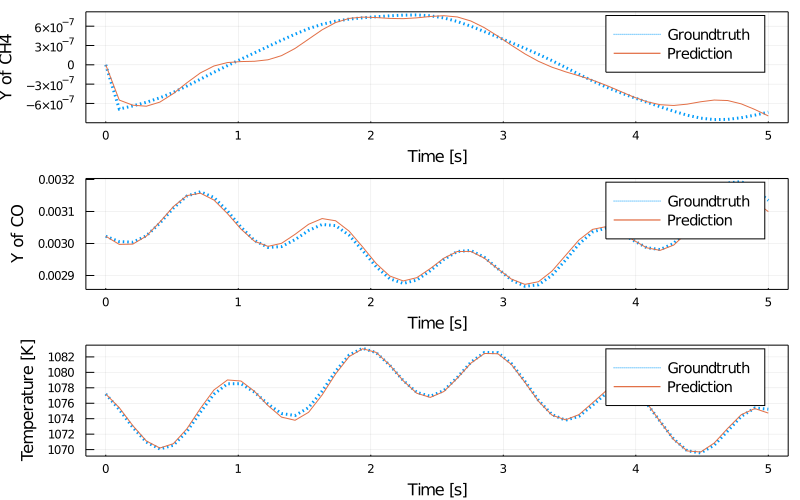

Loss ytrain 1.124e-03 gnorm 5.145e-01 100.0%┣██┫ 100/100 [04:10<00:00, 0.4 it/s]
Loss ytrain 1.124e-03 gnorm 5.145e-01 100.0%┣██┫ 100/100 [04:10<00:00, 0.4 it/s]



In [603]:
opt = ADAMW(5e-3, (0.9, 0.999), 1.f-6);
train(opt; n_epoch=100, batchsize=10, reltol=1e-6, abstol=1e-9)

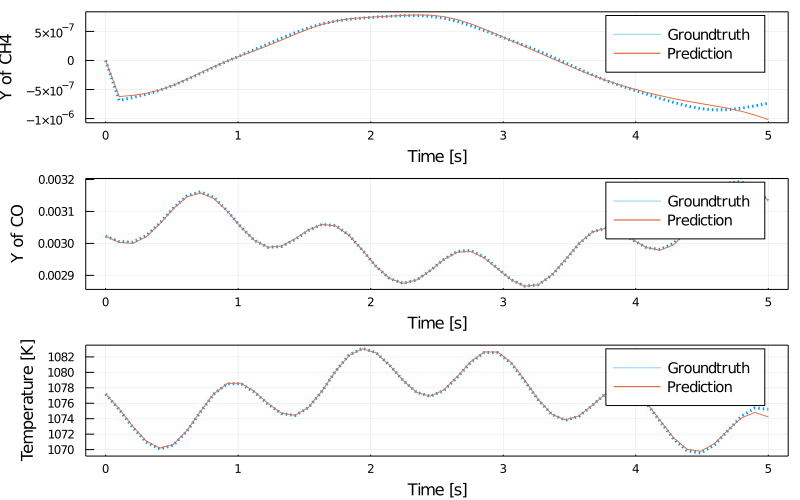

Loss ytrain 1.739e-04 gnorm 9.524e-02 100.0%┣██┫ 100/100 [04:09<00:00, 0.4 it/s]
Loss ytrain 1.739e-04 gnorm 9.524e-02 100.0%┣██┫ 100/100 [04:09<00:00, 0.4 it/s]



In [604]:
opt = ADAMW(1e-3, (0.9, 0.999), 1.f-6);
train(opt; n_epoch=100, batchsize=datasize>>1, reltol=1e-9, abstol=1e-12)

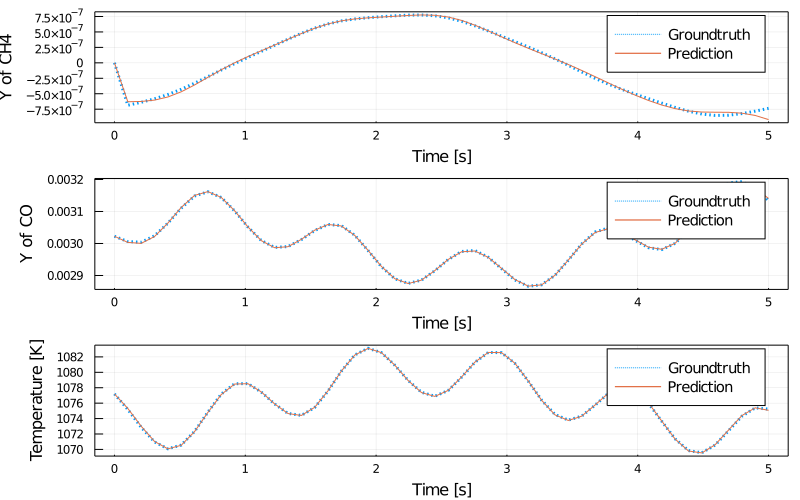

Loss ytrain 1.763e-05 gnorm 1.086e-02 100.0%┣██┫ 100/100 [05:14<00:00, 0.3 it/s]
Loss ytrain 1.763e-05 gnorm 1.086e-02 100.0%┣██┫ 100/100 [05:14<00:00, 0.3 it/s]



In [605]:
opt = ADAMW(1e-3, (0.9, 0.999), 1.f-6);
train(opt; n_epoch=100, batchsize=datasize, reltol=1e-9, abstol=1e-12)

In [589]:
#train(opt; n_epoch=500, batchsize=datasize, reltol=1e-9, abstol=1e-12)

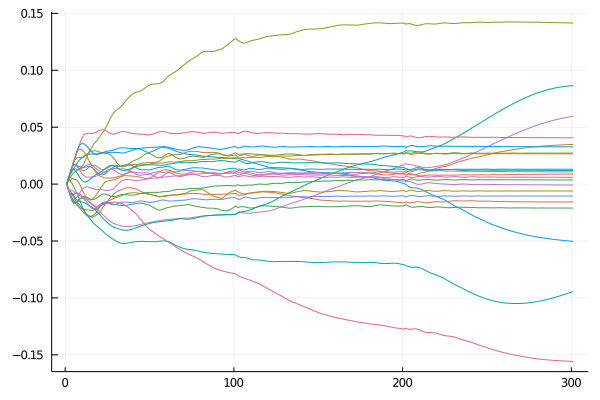

In [606]:
plot((hcat(history_p_pred...).- p_init)', label="")

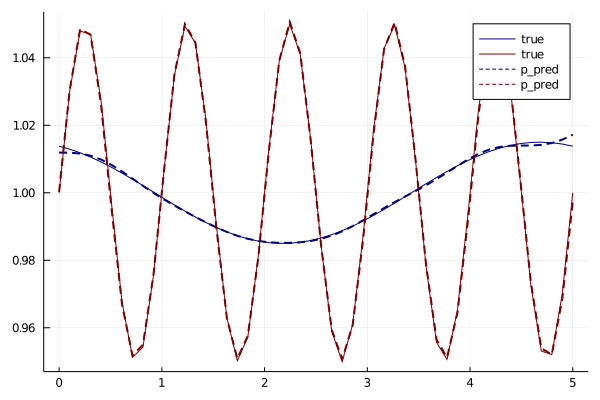

In [607]:
plot(palette=palette(:jet, 2))
plot!(tsteps, data', line=(1,:solid), label="true")
#plot!(tsteps, re(p_true)((tsteps./tscale)')', line=(3,:dot), label="p_true")
plot!(tsteps, re(p_pred)((tsteps./tscale)')', line=(2,:dash), label="p_pred")

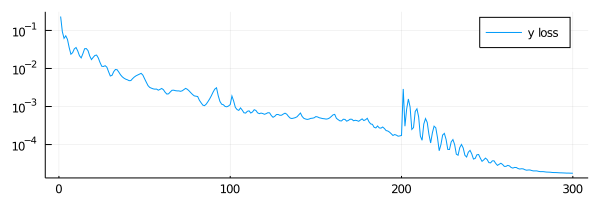

In [608]:
plot(losses_y_train, yscale=:log10, size=(600,200), label="y loss")

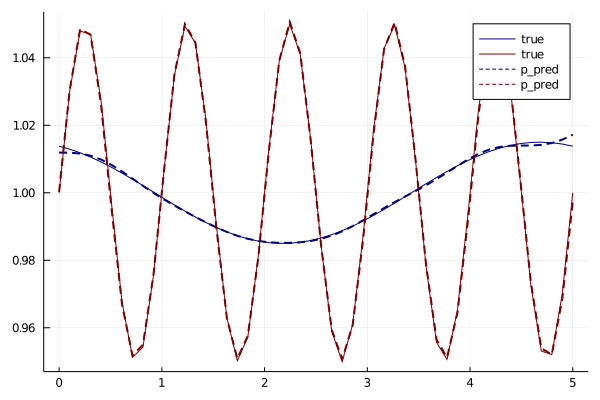

In [609]:
# show the optimization process
for p in history_p_pred

#     _prob = remake(probnn, u0=u0, p=p, tspan=tspan)
#     y_pred = Array(solve(_prob, solver, saveat=tsteps, sensalg=sensealg,
#                 reltol=reltol, abstol=abstol, verbose=false))
#     valid(tsteps, y_true, y_pred)
    IJulia.clear_output(true)
    h = plot(palette=palette(:jet, 2))
    plot!(tsteps, data', line=(1,:solid), label="true")
    plot!(tsteps, re(p)((tsteps./tscale)')', line=(2,:dash), label="p_pred")
    display(h)
    sleep(1e-3)
end